In [1]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# configure udtk as parent folder
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [4]:
#load original data
parcels = gpd.read_file('../carto/nyc_parcels.geojson')

In [5]:
grid = gpd.read_file('../carto/grid_8')

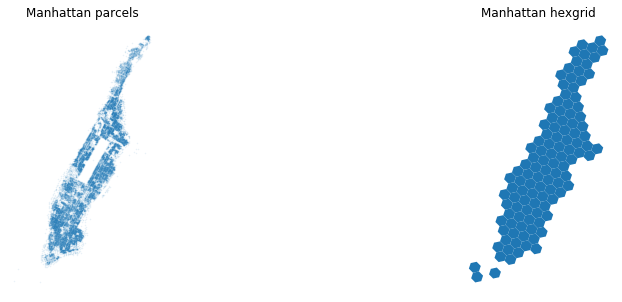

In [6]:
#plot hexgrid data
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

parcels.plot(ax=ax1, alpha=0.1,markersize=0.2)
grid.plot(ax=ax2)

ax1.set_axis_off()
ax1.set_title('Manhattan parcels')

ax2.set_axis_off()
ax2.set_title('Manhattan hexgrid');

### Part 1: Local indicators of spatial autocorrelation (LISA) 

In [7]:
import pickle

In [8]:
# loads the weight matrix
with open('../data/w_8.pickle', 'rb') as w_file:
    w = pickle.load(w_file)

In [9]:
from udtk.clustering import get_lisa_legacy

In [10]:
grid.head(5)

,h3_res_8,n,geometry
0,882a10085bfffff,2,"POLYGON ((-8231979.536 4991102.167, -8231487.4..."
1,882a100881fffff,290,"POLYGON ((-8234612.577 4983222.344, -8234120.8..."
2,882a100883fffff,962,"POLYGON ((-8234340.000 4982064.997, -8233848.3..."
3,882a100887fffff,102,"POLYGON ((-8235542.610 4982411.218, -8235050.8..."
4,882a100889fffff,533,"POLYGON ((-8233682.332 4984033.499, -8233190.5..."


In [11]:
# we get three objects:
get_lisa_legacy('../carto/grid_8/grid_8.shp', 'n', w, 'h3_res_8')

('WARNING: ', '882a1072b9fffff', ' is an island (no neighbors)')


{'gdf':             h3_res_8     n                                           geometry  \
 0    882a10085bfffff     2  POLYGON ((-8231979.536 4991102.167, -8231487.4...   
 1    882a100881fffff   290  POLYGON ((-8234612.577 4983222.344, -8234120.8...   
 2    882a100883fffff   962  POLYGON ((-8234340.000 4982064.997, -8233848.3...   
 3    882a100887fffff   102  POLYGON ((-8235542.610 4982411.218, -8235050.8...   
 4    882a100889fffff   533  POLYGON ((-8233682.332 4984033.499, -8233190.5...   
 ..               ...   ...                                                ...   
 108  882a1072cbfffff  1102  POLYGON ((-8236421.806 4971887.302, -8235930.7...   
 109  882a1072cdfffff  1267  POLYGON ((-8237895.511 4973387.695, -8237404.2...   
 110  882a1072d5fffff    83  POLYGON ((-8237077.550 4969923.045, -8236586.5...   
 111  882a1072d9fffff    15  POLYGON ((-8234948.757 4970387.124, -8234457.8...   
 112  882a1072ddfffff   493  POLYGON ((-8236149.370 4970732.465, -8235658.3...   
 
      s

In [12]:
# stores the objects:
spatial_corr = get_lisa_legacy('../carto/grid_8/grid_8.shp', 'n', w, 'h3_res_8')

In [13]:
# the first one is a geodataframe with the entire grid information (statistical significance and quadrants)
spatial_corr['gdf'].head()

,h3_res_8,n,geometry,significant,quadrant
0,882a10085bfffff,2,"POLYGON ((-8231979.536 4991102.167, -8231487.4...",False,3
1,882a100881fffff,290,"POLYGON ((-8234612.577 4983222.344, -8234120.8...",False,2
2,882a100883fffff,962,"POLYGON ((-8234340.000 4982064.997, -8233848.3...",False,4
3,882a100887fffff,102,"POLYGON ((-8235542.610 4982411.218, -8235050.8...",False,2
4,882a100889fffff,533,"POLYGON ((-8233682.332 4984033.499, -8233190.5...",False,4


In [14]:
# also the Moran I value to know the correlation of the 'indicator' value (n) with his neighboring values
spatial_corr['value']

0.306697594109885

In [15]:
# and the statistical significance. We can reject the null hypothesis of 'spatial randomness'! 
spatial_corr['significance']

0.001

In [16]:
# pysal viz modules
from pysal.viz.splot.esda import plot_moran
from pysal.viz.splot.esda import moran_scatterplot
from pysal.viz import splot
from pysal.viz.splot.esda import lisa_cluster

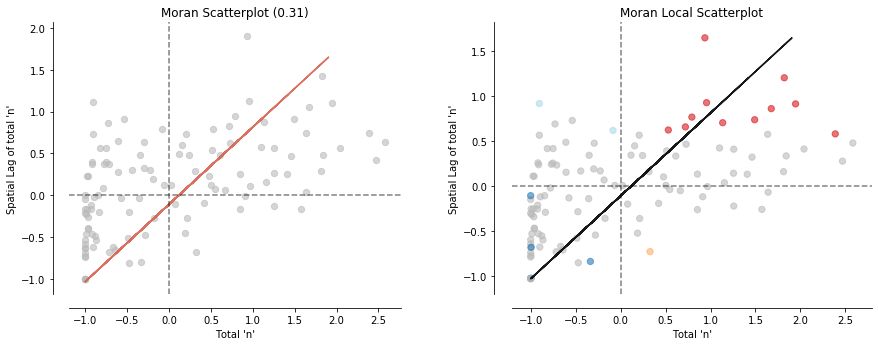

In [17]:
# We can plot both moran and local moran to check the association level, hot and cold spots
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

moran_scatterplot(spatial_corr['moran'], ax=ax1)
ax1.set_xlabel('Total \'n\'')
ax1.set_ylabel('Spatial Lag of total \'n\'')

# get lisa to show quadrants
moran_scatterplot(spatial_corr['local'],ax=ax2, p=0.05)
ax2.set_xlabel('Total \'n\'')
ax2.set_ylabel('Spatial Lag of total \'n\'')
plt.show();

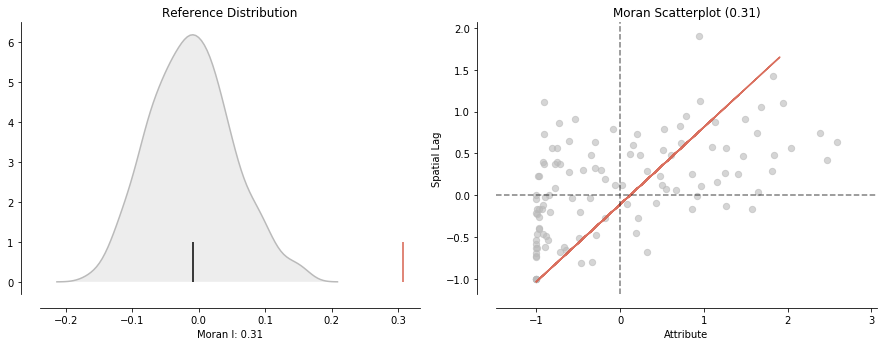

In [18]:
plot_moran(spatial_corr['moran'], zstandard=True, figsize=(15,5))
plt.show()

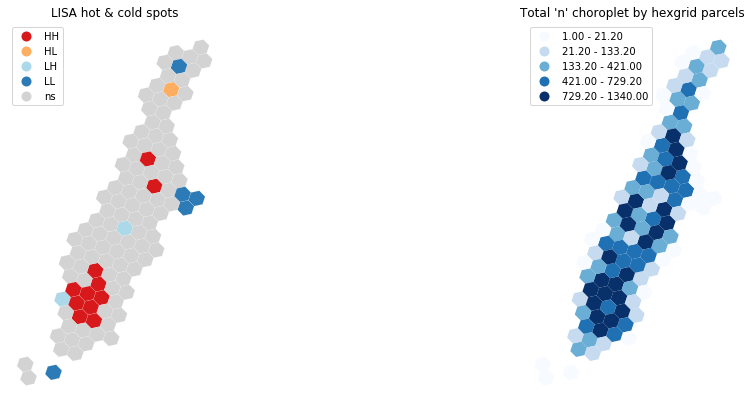

In [19]:
fig = plt.figure(figsize=(17,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

lisa_cluster(spatial_corr['local'], spatial_corr['gdf'], p=0.05, ax=ax1, legend_kwds={'loc': 'upper left'})
ax1.set_title('LISA hot & cold spots')

# Use a choroplet to see where are the highest values of the current indicator: total households
spatial_corr['gdf'].plot(ax=ax2,
                         column='n',
                         cmap='Blues',
                         scheme='quantiles',
                         k=5,
                         legend=True, 
                         legend_kwds={'loc': 'upper left'})
ax2.set_title('Total \'n\' choroplet by hexgrid parcels')
ax2.set_axis_off()

plt.show()

### Choosing quadrants... 

In [20]:
# if we want to work just wigth high-high values
from udtk.clustering import select_quadrant as sq

carto = spatial_corr['gdf']

# we can use the entire gdf
hh_gdf = sq(carto, 1)['quadrant_gdf']
# ... or the coordinate values
hh_coord = sq(carto, 1)['quadrant_array']

#### Why high-high values? (brief explanation about how LISA is working)

We will build clusters following the idea of high values sorrounded by similar values of the same variable of interest.

#### Spatial lag

...the spatial lag is the product of the spatial weights matrix and a given variable.The result amounts to the average value of the variable in the neighborhood of each observation.

In [21]:
import pysal as ps
grid['total_n_lag'] = ps.lib.weights.lag_spatial(w, grid['n'])

In [22]:
# The '882a10085bfffff' hex polygon has 2 'n' and is sorrounded by other polygons with an avg of 105.6 'n'.
grid.head()

,h3_res_8,n,geometry,total_n_lag
0,882a10085bfffff,2,"POLYGON ((-8231979.536 4991102.167, -8231487.4...",105.666667
1,882a100881fffff,290,"POLYGON ((-8234612.577 4983222.344, -8234120.8...",487.000000
2,882a100883fffff,962,"POLYGON ((-8234340.000 4982064.997, -8233848.3...",313.833333
3,882a100887fffff,102,"POLYGON ((-8235542.610 4982411.218, -8235050.8...",698.666667
4,882a100889fffff,533,"POLYGON ((-8233682.332 4984033.499, -8233190.5...",340.800000


In [23]:
# let's check the lag value for our '882a10085bfffff' polygon
grid.set_index('h3_res_8').loc['882a10085bfffff']

n                                                              2
geometry       POLYGON ((-8231979.535585709 4991102.166847879...
total_n_lag                                              105.667
Name: 882a10085bfffff, dtype: object

In [24]:
# we see that the avg of his neighbors is the same: '882a10085bfffff' is sorrounded by other polygon with an avg of 105 'n'
grid.set_index('h3_res_8').loc[w.neighbors['882a10085bfffff'], 'n'].mean()

105.66666666666667

### Part 2: clustering witgh DBSCAN 

In [25]:
from sklearn.cluster import DBSCAN

In [26]:
# we will run DBSCAN to identify which points are closest to each other and get the cluster label
from udtk.clustering import cluster_labels as cl

In [27]:
# eps and min_samples can be consumed from a yaml file 
cl(eps = 1200, min_samples = 1, quadrant_array = hh_coord)

array([0, 1, 2, 2, 3, 2, 4, 4, 3, 3, 4])

In [28]:
# assign the cluster label to the high-high values geodataframe (it is important to name it as 'k'!)
hh = hh_gdf.copy()

hh['k'] = cl(eps = 1200, min_samples = 1, quadrant_array = hh_coord)

In [29]:
import random

In [30]:
# get a color list to plot DBSCAN cluster groups
hex_col = []
for i in hh['k'].unique():
    rgb = lambda: random.randint(0,255)
    hex_col.append('#%02X%02X%02X' % (rgb(),rgb(),rgb()))

In [31]:
hex_col

['#3A2E39', '#782288', '#55B365', '#F3F761', '#47883E']

In [32]:
# let's try with different DBSCAN parameters and checks how many clusters do we get. This time with 3 neighbours
hh['k2'] = cl(eps = 1200, min_samples = 3, quadrant_array = hh_coord)

hhk2_col = []
for i in hh['k2'].unique():
    rgb = lambda: random.randint(0,255)
    hhk2_col.append('#%02X%02X%02X' % (rgb(),rgb(),rgb()))

In [33]:
# ... and also 5 neighbours.
hh['k3'] = cl(eps = 1200, min_samples = 5, quadrant_array = hh_coord)

hhk3_col = []
for i in hh['k3'].unique():
    rgb = lambda: random.randint(0,255)
    hhk3_col.append('#%02X%02X%02X' % (rgb(),rgb(),rgb()))

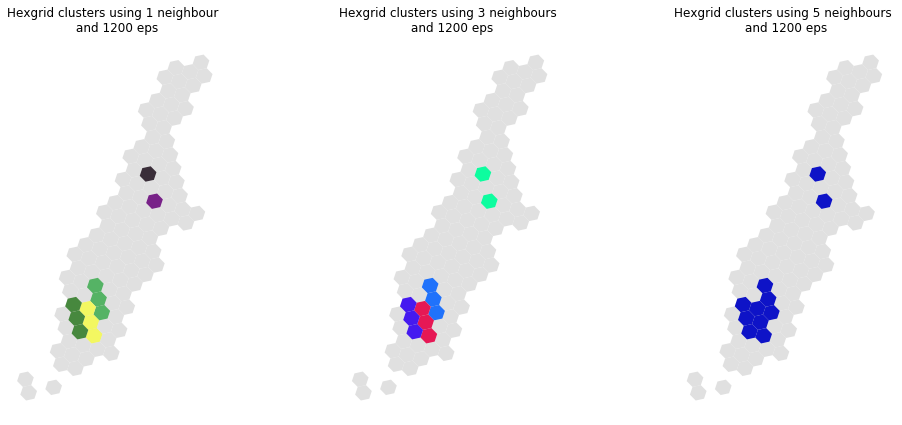

In [34]:
fig = plt.figure(figsize=(17,7))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# use the hexgrid as basemap to show clusters contrast
grid.plot(ax=ax1, alpha=0.7,color='lightgrey')
grid.plot(ax=ax2, alpha=0.7,color='lightgray')
grid.plot(ax=ax3, alpha=0.7,color='lightgray')

# 1 neighbour
for i in hh['k'].unique():
    hh.loc[hh['k']==i].plot(ax = ax1, color=hex_col[i])
# 3 neighbours    
for i in hh['k2'].unique():
    hh.loc[hh['k2']==i].plot(ax = ax2, color=hhk2_col[i])
# 5 neighbours111
for i in hh['k3'].unique():
    hh.loc[hh['k3']==i].plot(ax = ax3, color=hhk3_col[i])

ax1.set_title('Hexgrid clusters using 1 neighbour \n and 1200 eps')    
ax1.set_axis_off()

ax2.set_title('Hexgrid clusters using 3 neighbours \n and 1200 eps')
ax2.set_axis_off()

ax3.set_title('Hexgrid clusters using 5 neighbours \n and 1200 eps')
ax3.set_axis_off()

### Part 3: What do we get in the end? 

In [35]:
from udtk.clustering import make_convex_cluster as convex
from udtk.clustering import build_clusters as bc

In [36]:
hh.head()

,h3_res_8,n,geometry,significant,quadrant,k,k2,k3
22,882a1008cbfffff,671,"POLYGON ((-8231821.203 4985655.897, -8231329.4...",True,1,0,-1,-1
24,882a1008d1fffff,573,"POLYGON ((-8231276.895 4983340.256, -8230785.3...",True,1,1,-1,-1
59,882a100d21fffff,732,"POLYGON ((-8236038.186 4975007.754, -8235546.9...",True,1,2,0,-1
60,882a100d23fffff,799,"POLYGON ((-8235765.691 4973852.229, -8235274.5...",True,1,2,0,-1
62,882a100d27fffff,1055,"POLYGON ((-8236966.954 4974197.710, -8236475.6...",True,1,3,1,-1


In [37]:
import pysal as ps

In [38]:
bc(hh, 'n', 'h3_res_8',0)['clusters']

,k,geometry
0,0,"POLYGON ((-8232260.141 4984343.184, -8232751.8..."
1,1,"POLYGON ((-8231715.787 4982028.135, -8232207.3..."
2,2,"POLYGON ((-8236203.142 4972542.203, -8236694.3..."
3,3,"POLYGON ((-8236859.010 4970577.723, -8237350.1..."
4,4,"POLYGON ((-8238059.767 4970922.845, -8238550.9..."


In [39]:
clusters = bc(hh, 'n', 'h3_res_8',0)['clusters']

In [40]:
hh_indicator = bc(hh, 'n', 'h3_res_8',0)['indicator']

In [41]:
from udtk.clustering import cluster_processing as clpro

In [42]:
c_points = clpro(clusters, carto,hh_indicator, 2006,'n', 'viridis')['cluster_points']

In [43]:
c_polygons = clpro(clusters, carto,hh_indicator, 2006,'n', 'viridis')['cluster_polygons']

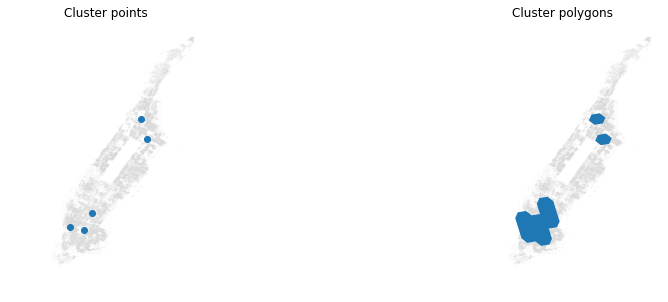

In [44]:
# this is what we get after applying lisa, dbscan and convex hull:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

parcels.to_crs(crs=c_points.crs).plot(ax=ax1, alpha=0.1,markersize=0.2, color='lightgray')
parcels.to_crs(crs=c_points.crs).plot(ax=ax2, alpha=0.1,markersize=0.2, color='lightgray')

# cluster points
c_points.plot(ax=ax1)
# cluster polygons
c_polygons.plot(ax=ax2)
                                      
ax1.set_axis_off()
ax1.set_title('Cluster points')

ax2.set_axis_off()
ax2.set_title('Cluster polygons');